# Dataset link -
##### https://data.mendeley.com/datasets/748f8jkphb/3

# Testing if GPU active

In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(
            gpu,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
        )
else:
    print("No GPUs available.")

In [4]:
! nvidia-smi

Wed Sep 27 22:30:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              11W / 136W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Image Augmentation for Balancing Data

In [5]:
import os
import shutil
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img
from tqdm import tqdm

In [26]:
input_data_dir = 'Dataset\Plants'
output_data_dir = 'Dataset\Plants'
target_num_images = 240

In [27]:
def augment_and_save_images(class_folder, image_names):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    output_class_path = os.path.join(output_data_dir, class_folder)
    os.makedirs(output_class_path, exist_ok=True)

    num_images_to_generate = target_num_images - len(image_names)

    if num_images_to_generate > 0:
        for i in tqdm(range(num_images_to_generate), desc=f'Augmenting {class_folder}'):
            random_image_name = random.choice(image_names)
            image_path = os.path.join(input_data_dir, class_folder, random_image_name)

            img = load_img(image_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1):
                augmented_img = array_to_img(batch[0])
                augmented_image_name = f"augmented_{random.randint(1, 100000)}.jpg"
                output_path = os.path.join(output_class_path, augmented_image_name)
                augmented_img.save(output_path)
                break

In [28]:
for class_folder in os.listdir(input_data_dir):
    class_path = os.path.join(input_data_dir, class_folder)
    existing_images = [image_name for image_name in os.listdir(class_path) if image_name.endswith('.jpg')]
    augment_and_save_images(class_folder, existing_images)

Augmenting Curry_Leaf: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


In [29]:
import matplotlib.pyplot as plt

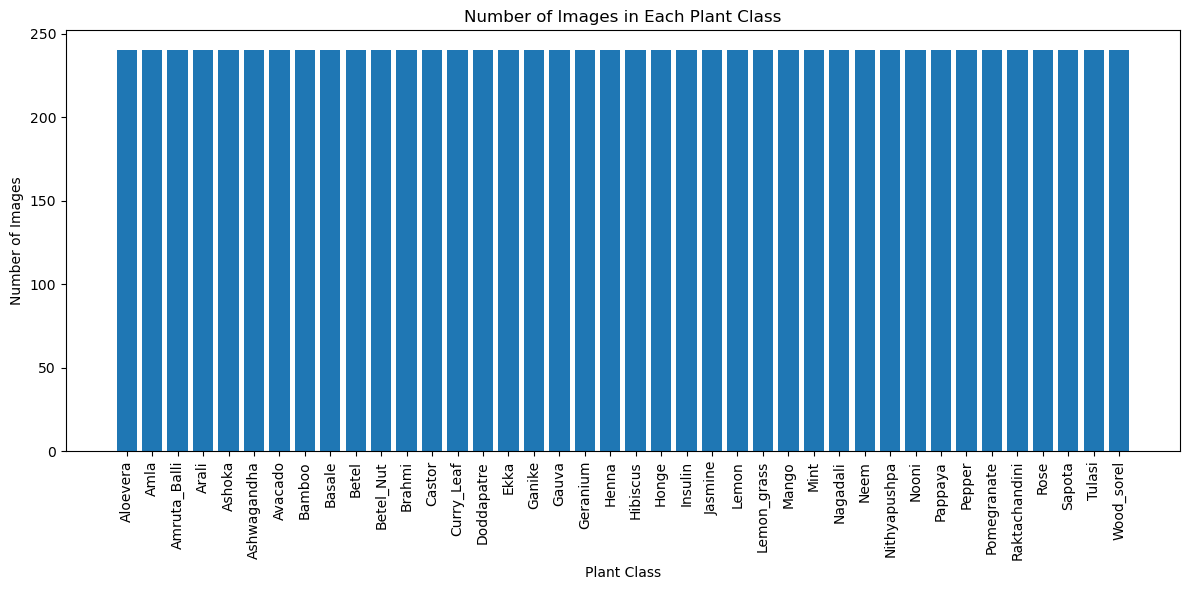

In [30]:
root_directory = 'Dataset/Plants'

class_names = []
image_counts = []

for class_folder in os.listdir(root_directory):
    class_path = os.path.join(root_directory, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        image_counts.append(len(os.listdir(class_path)))


plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts)
plt.xlabel('Plant Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Plant Class')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# Splitting to Test and Train data

In [31]:
output_directory_test_train = 'Dataset/'
os.makedirs(os.path.join(output_directory_test_train, 'Train'), exist_ok=True)
os.makedirs(os.path.join(output_directory_test_train, 'Test'), exist_ok=True)

In [32]:
os.listdir(output_directory_test_train)
train_ratio = 0.8

In [33]:
for class_folder in os.listdir(input_data_dir):
    class_path = os.path.join(input_data_dir, class_folder)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        num_images = len(image_files)
        num_train = int(train_ratio * num_images)

        train_class_dir = os.path.join(output_directory_test_train, 'Train', class_folder)
        test_class_dir = os.path.join(output_directory_test_train, 'Test', class_folder)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for i, image_file in enumerate(tqdm(image_files, desc=f'Copying {class_folder}')):
            source_path = os.path.join(class_path, image_file)
            if i < num_train:
                destination_path = os.path.join(train_class_dir, image_file)
            else:
                destination_path = os.path.join(test_class_dir, image_file)
            shutil.copyfile(source_path, destination_path)

Copying Wood_sorel: 100%|██████████| 240/240 [00:00<00:00, 2839.45it/s]


# Checking, Resizing, Vectorizing Images

In [34]:
import numpy as np
from sklearn.utils import shuffle
import cv2

In [35]:
dataset_directory = 'Dataset/Plants/'

In [36]:
image_class_name = [image_class for image_class in os.listdir(dataset_directory)]
image_class_name_label = {image_class:index for index, image_class in enumerate(image_class_name)}
total_class = len(image_class_name)
IMAGE_SIZE = (160,160)

In [37]:
def pre_process(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    return image

In [38]:
def load_data():
    
    datasets = ['Dataset/Train/', 'Dataset/Test/']
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print(f"Loading {dataset}")
        
        for folder in os.listdir(dataset):
            label = image_class_name_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = pre_process(img_path) 
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [39]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading Dataset/Train/


100%|██████████| 192/192 [00:01<00:00, 139.10it/s]


Loading Dataset/Test/


100%|██████████| 63/63 [00:00<00:00, 181.25it/s]


In [40]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [41]:
number_train = train_labels.shape[0]
number_test = test_labels.shape[0]

print (f"Number of training examples: {number_train}")
print (f"Number of testing examples: {number_test}")
print (f"Each image is of size: {IMAGE_SIZE}")

Number of training examples: 7680
Number of testing examples: 2476
Each image is of size: (160, 160)


In [42]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [43]:
train_images

array([[[[0.6666667 , 0.627451  , 0.4862745 ],
         [0.6666667 , 0.6313726 , 0.49019608],
         [0.6509804 , 0.61960787, 0.4745098 ],
         ...,
         [0.40784314, 0.44313726, 0.34901962],
         [0.40392157, 0.45882353, 0.3529412 ],
         [0.3882353 , 0.4117647 , 0.32156864]],

        [[0.65882355, 0.627451  , 0.48235294],
         [0.6313726 , 0.6       , 0.45882353],
         [0.6666667 , 0.63529414, 0.49019608],
         ...,
         [0.3764706 , 0.4392157 , 0.3372549 ],
         [0.29803923, 0.43529412, 0.33333334],
         [0.25490198, 0.3647059 , 0.27058825]],

        [[0.6156863 , 0.59607846, 0.44705883],
         [0.6392157 , 0.61960787, 0.47058824],
         [0.6666667 , 0.63529414, 0.49019608],
         ...,
         [0.2784314 , 0.37254903, 0.2627451 ],
         [0.22745098, 0.34509805, 0.23529412],
         [0.28627452, 0.39215687, 0.2784314 ]],

        ...,

        [[0.98039216, 0.83137256, 0.63529414],
         [0.9764706 , 0.83137256, 0.60784316]

In [44]:
test_images

array([[[[0.38431373, 0.3764706 , 0.3882353 ],
         [0.39607844, 0.3882353 , 0.4       ],
         [0.43137255, 0.42352942, 0.43529412],
         ...,
         [0.78431374, 0.76862746, 0.7647059 ],
         [0.6901961 , 0.6509804 , 0.64705884],
         [0.6745098 , 0.63529414, 0.627451  ]],

        [[0.4392157 , 0.43137255, 0.44313726],
         [0.44705883, 0.4392157 , 0.4509804 ],
         [0.41960785, 0.4117647 , 0.42352942],
         ...,
         [0.6666667 , 0.6313726 , 0.63529414],
         [0.6431373 , 0.6039216 , 0.6       ],
         [0.6313726 , 0.5882353 , 0.5882353 ]],

        [[0.40784314, 0.4       , 0.4117647 ],
         [0.42745098, 0.41960785, 0.43137255],
         [0.45882353, 0.4509804 , 0.4627451 ],
         ...,
         [0.62352943, 0.58431375, 0.5882353 ],
         [0.6666667 , 0.627451  , 0.62352943],
         [0.6666667 , 0.627451  , 0.62352943]],

        ...,

        [[0.38431373, 0.46666667, 0.45882353],
         [0.40784314, 0.4509804 , 0.44313726]

# Displaying Sample Images

In [45]:
def display_examples(image_class_name, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(image_class_name[labels[i]])
    plt.show()

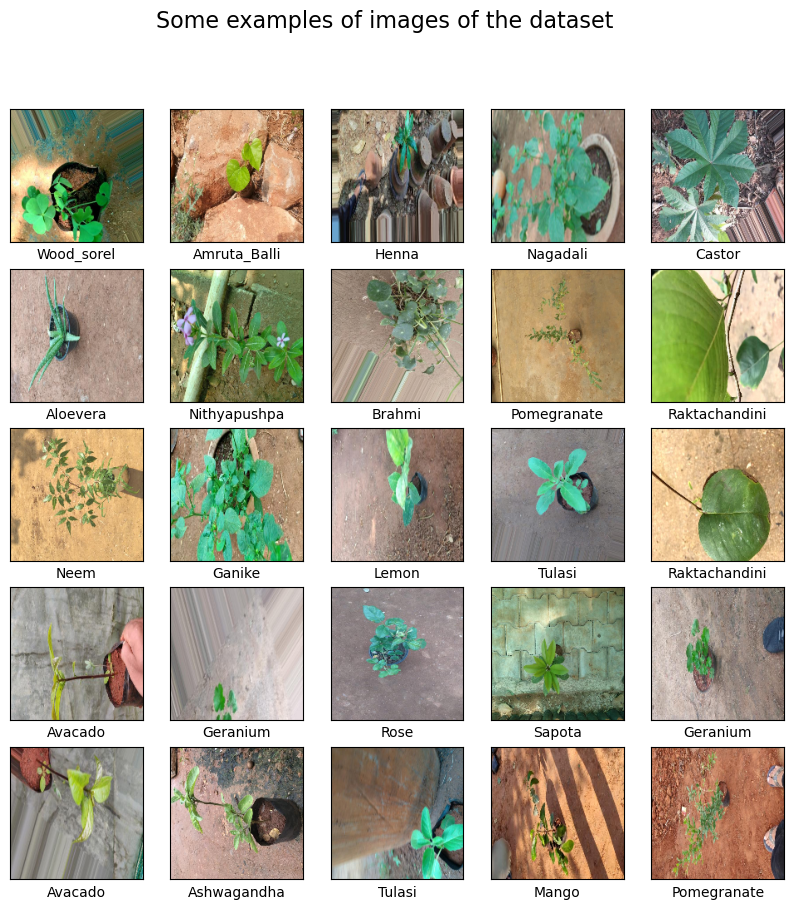

In [46]:
display_examples(image_class_name, train_images, train_labels)

# Model Import and Configuration

MobileNetV2 also crashing

In [47]:
from keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160,160,3))

In [48]:
from keras import layers

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  
    layers.Dense(256, activation='relu'),  
    layers.Dropout(0.5),
    layers.Dense(40, activation='softmax')
])

In [49]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.001  
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.1  
    else:
        return initial_lr * 0.01  

In [50]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [51]:
from keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),  
              metrics=['accuracy'])


In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                10280     
                                                                 
Total params: 2,596,200
Trainable params: 338,216
Non-tr

In [53]:
from keras.utils import to_categorical

train_labels_encoded = to_categorical(train_labels, num_classes=40)
test_labels_encoded = to_categorical(test_labels, num_classes=40)

In [54]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [55]:
history = model.fit(train_images, train_labels, epochs=50, batch_size=8, validation_split=0.2, callbacks=[early_stopping, lr_scheduler]) 

Epoch 1/50
768/768 [==============================] - 14s 11ms/step - loss: 2.1798 - accuracy: 0.4136 - val_loss: 1.0670 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 2/50
768/768 [==============================] - 7s 9ms/step - loss: 1.1582 - accuracy: 0.6553 - val_loss: 0.6730 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 3/50
768/768 [==============================] - 7s 9ms/step - loss: 0.8667 - accuracy: 0.7367 - val_loss: 0.6103 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 4/50
768/768 [==============================] - 7s 9ms/step - loss: 0.7112 - accuracy: 0.7796 - val_loss: 0.5055 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 5/50
768/768 [==============================] - 7s 9ms/step - loss: 0.6033 - accuracy: 0.8128 - val_loss: 0.4994 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 6/50
768/768 [==============================] - 7s 9ms/step - loss: 0.5546 - accuracy: 0.8278 - val_loss: 0.4800 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 7/50
768/768 [==============================] - 7s 9ms/step - 

In [56]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy}')

78/78 [==============================] - 2s 18ms/step - loss: 0.5521 - accuracy: 0.8469
Test accuracy: 0.8469305038452148


In [58]:
model.save('Herbal-AI-Classification.h5')
model.save_weights('Herbal-AI-Classification-Weights.h5')

# Testing the Model

In [59]:
from keras.models import load_model
model = load_model("Herbal-AI-Classification.h5")

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                10280     
                                                                 
Total params: 2,596,200
Trainable params: 338,216
Non-tr

In [83]:
image_class_name = [image_class for image_class in os.listdir(dataset_directory)]

In [77]:
import cv2
import numpy as np

test_image_path = "test_image.jpg"

img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (160,160)) 

In [78]:
img = np.expand_dims(img, axis=0)
img = np.array(img, dtype = 'float32')
img /= 255.0  

In [79]:
predictions = model.predict(img)

1/1 [==============================] - 1s 569ms/step


In [85]:
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = image_class_name[predicted_class_index]
print("Predicted Class Index:", predicted_class_name)

Predicted Class Index: Nagadali


VGG16 using all the VRAM and RAM

In [ ]:
# from keras.applications.vgg16 import VGG16
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D

# custom_top_model = base_model.output
# custom_top_model = GlobalAveragePooling2D()(custom_top_model)
# custom_top_model = Dense(256, activation='relu')(custom_top_model)
# custom_top_model = Dense(40, activation='softmax')(custom_top_model)

# model = Model(inputs=base_model.input, outputs=custom_top_model)

Custom Layers

In [ ]:
# from keras import layers, models
# model = models.Sequential()

In [ ]:
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))

In [ ]:
# model.add(layers.Flatten())

In [ ]:
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(40, activation='softmax'))